In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=67b95ac38b5399833d74f0dcd49b7bc54fc7e794ec3ee08459f6ca62ad860c6a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=8a815ef63db282f2cef9bf584dde1c3176ae9f467850b4871303399458255181
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.67 MiB/s, done.


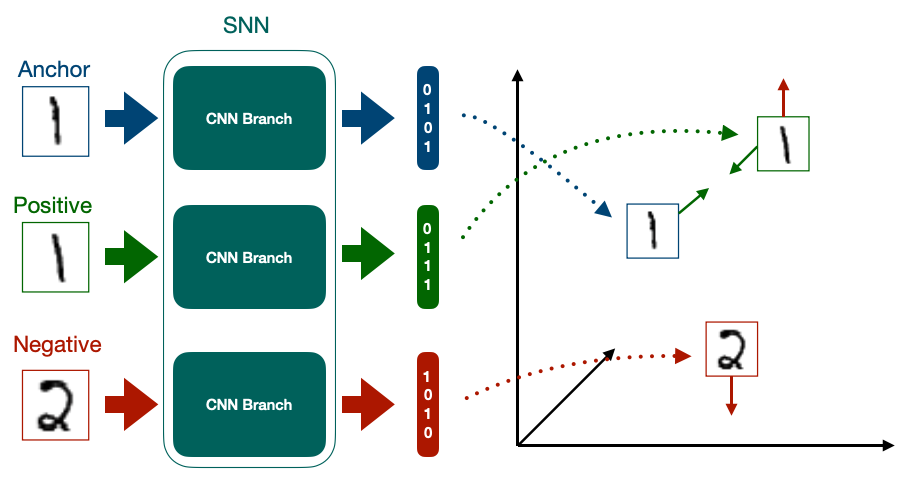

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

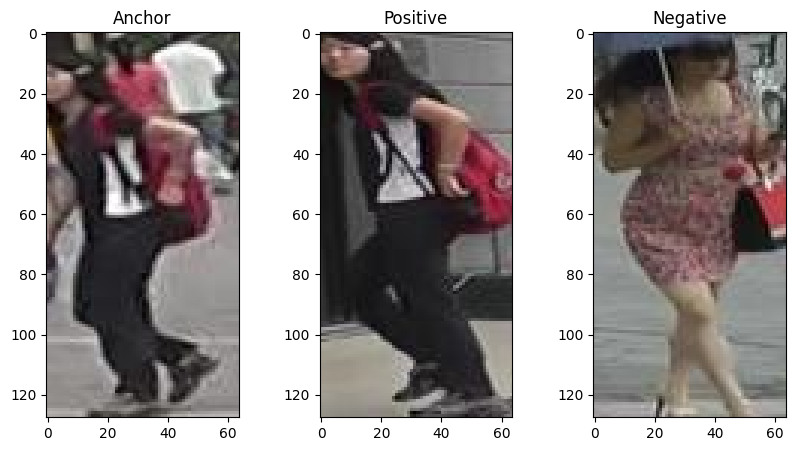

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size= 0.2, random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):
  def __init__(self,df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)
    A_img = torch.from_numpy(A_img).permute(2,0,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0
    return A_img,P_img,N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


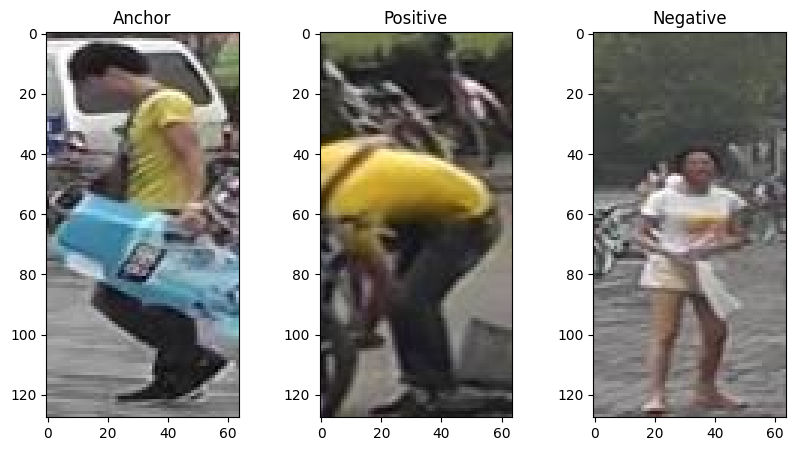

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):
  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)
  def forward(self,images):
    embeddings = self.efficientnet(images)
    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [ ]:
def train_fn(model,dataloader,optimizer,criterion):
  model.train() # ON Dropout
  total_loss = 0.0
  for A,P,N in tqdm(dataloader):
    A,P,N = A.to(DEVICE),P.to(DEVICE),N.to(DEVICE)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    loss = criterion(A_embs, P_embs,N_embs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model,dataloader,criterion):
  model.eval() # OFF Dropout
  total_loss = 0.0
  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A,P,N = A.to(DEVICE),P.to(DEVICE),N.to(DEVICE)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)
      loss = criterion(A_embs, P_embs,N_embs)
      total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader,optimizer,criterion)
  valid_loss = eval_fn(model,validloader,criterion)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS: {i+1} train loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.92it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 1 train loss: 0.6628779104351997 valid_loss: 0.664068363904953


100%|██████████| 25/25 [00:02<00:00,  9.76it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 2 train loss: 0.3307562507688999 valid_loss: 0.5128720474243164


100%|██████████| 25/25 [00:02<00:00, 10.56it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 3 train loss: 0.19795300632715226 valid_loss: 0.35726905703544615


100%|██████████| 25/25 [00:02<00:00, 10.58it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 4 train loss: 0.16559660844504834 valid_loss: 0.229537473320961


100%|██████████| 25/25 [00:02<00:00,  8.71it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 5 train loss: 0.0906231501698494 valid_loss: 0.2084384196996689


100%|██████████| 25/25 [00:02<00:00, 10.74it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 6 train loss: 0.07018442496657372 valid_loss: 0.15810641765594483


100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


EPOCHS: 7 train loss: 0.06531873598694801 valid_loss: 0.22212709128856659


100%|██████████| 25/25 [00:02<00:00,  8.76it/s]


EPOCHS: 8 train loss: 0.06728394836187362 valid_loss: 0.24321907579898835


100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


EPOCHS: 9 train loss: 0.08397170588374138 valid_loss: 0.17100104570388794


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


EPOCHS: 10 train loss: 0.051129160597920414 valid_loss: 0.1941859894990921


100%|██████████| 25/25 [00:03<00:00,  8.18it/s]


EPOCHS: 11 train loss: 0.04119081631302834 valid_loss: 0.20650288283824922


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


EPOCHS: 12 train loss: 0.040217576324939726 valid_loss: 0.16779299974441528


100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


EPOCHS: 13 train loss: 0.029607276543974877 valid_loss: 0.1628484970331192


100%|██████████| 25/25 [00:03<00:00,  7.82it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 14 train loss: 0.025297916531562804 valid_loss: 0.133981329202652


100%|██████████| 25/25 [00:02<00:00, 10.19it/s]

EPOCHS: 15 train loss: 0.033904354572296146 valid_loss: 0.1929369503259659


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) # add batch -> (batch, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [01:06<00:00, 60.13it/s]


In [ ]:
df_enc.to_csv('/content/database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.652485,-0.605368,0.004104,-0.061363,-0.053480,0.227739,-0.132613,-0.062674,-1.018334,...,0.718662,-0.069128,0.336875,0.508539,0.661172,-0.992749,0.666008,-0.369537,-0.182695,-0.436255
1,1420_c3s3_061978_03.jpg,-0.292980,-1.064736,-0.071406,-0.367609,0.331121,0.448579,0.391321,0.123053,-1.917756,...,0.612225,-0.418844,0.200303,-0.101844,0.244649,0.122511,0.799940,-0.739435,-0.526042,0.315419
2,1420_c5s3_062565_05.jpg,-0.278219,-0.326871,0.128514,-0.213227,0.098066,0.149703,-0.122896,-0.038410,-1.189027,...,0.604601,0.139128,0.233388,0.329114,0.338475,-0.608210,0.483937,-0.272664,-0.104206,-0.032593
3,1420_c6s3_085592_04.jpg,-0.522847,-0.978780,0.032434,-0.554053,-0.009929,0.599259,0.074523,0.402995,-1.186749,...,0.893731,0.011300,0.356928,-0.002368,0.837083,-0.597041,0.582669,-0.875994,-0.008944,-0.200661
4,0663_c5s3_085987_03.jpg,0.244191,-0.062884,-0.601848,-0.862826,0.122717,0.093384,0.248415,0.684078,0.509796,...,-0.426931,0.329223,-0.791467,-0.834508,-0.652935,0.073645,-1.052439,0.296345,-0.014622,0.156131


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1 :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


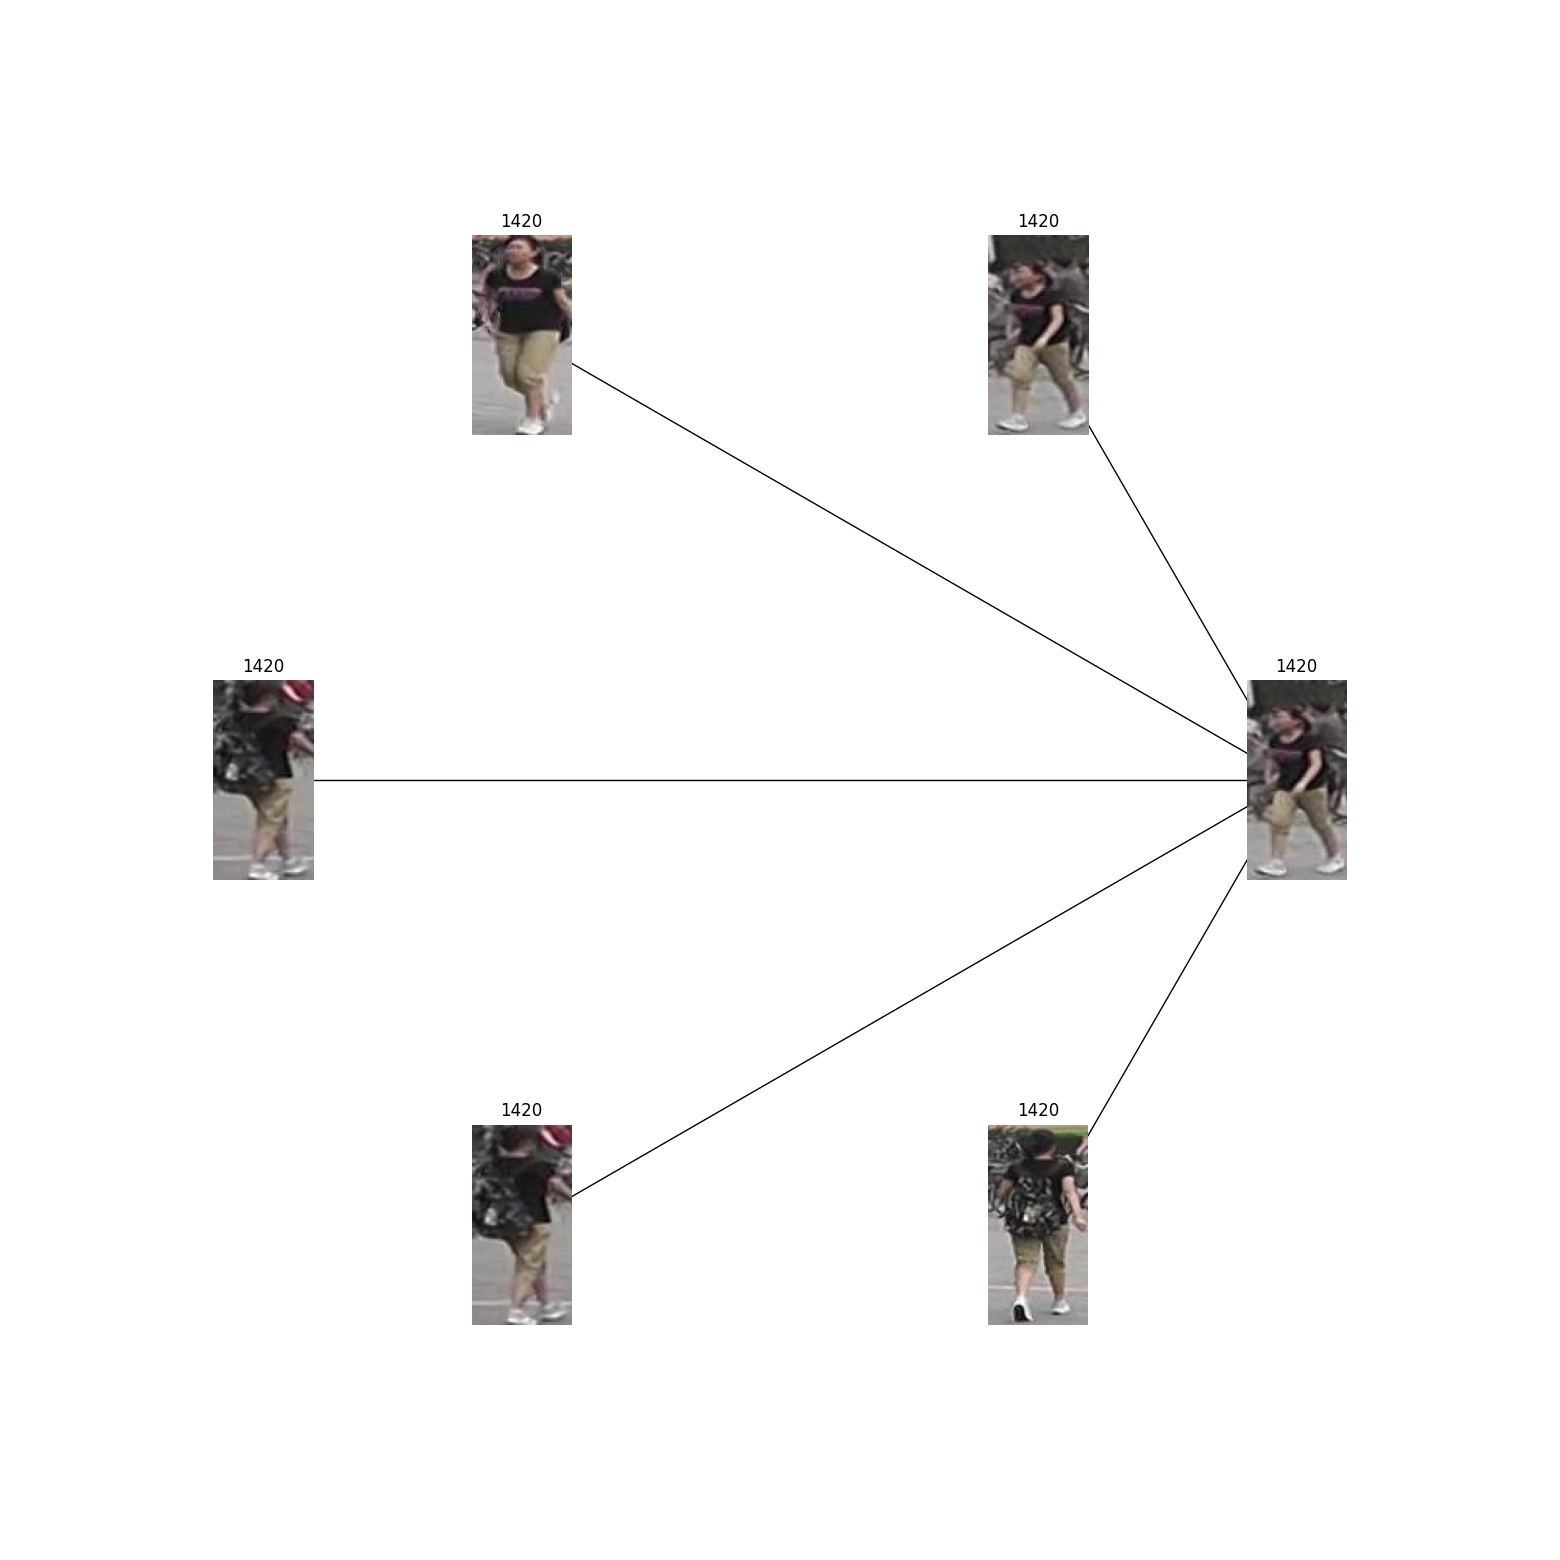

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);